### Train a particular convolutional neural network on MNIST data. Experiment with different number of parameters and plot corresponding training & validation error rates.  

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Convert labels to one-hot vectors

# Convert classes to indicator vectors
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values,np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

/software/Anaconda3-5.0.1-el7-x86_64/envs/DL_GPU_cuda_9.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Get Mnist data and split into train validation and test

In [2]:
def get_mnist():

    data=np.float64(np.load('/project/cmsc25025/mnist/MNIST.npy'))
    labels=np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))
    print(data.shape)
    data=np.float32(data)/255.
    train_dat=data[0:50000]
    train_labels=one_hot(np.int32(labels[0:50000]))
    val_dat=data[50000:60000]
    val_labels=one_hot(np.int32(labels[50000:60000]))
    test_dat=data[60000:70000]
    test_labels=one_hot(np.int32(labels[60000:70000]))
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

Get CIFAR10 data and split into train validation and test

In [3]:
def get_cifar():
    tr=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10.npy'))
    tr_lb=np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:45000]/255.
    train_labels=one_hot(tr_lb[0:45000])
    val_data=tr[45000:]/255.
    val_labels=one_hot(tr_lb[45000:])
    test_data=np.float32(np.load('/project/cmsc25025/mnist/CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('/project/cmsc25025/mnist/CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

Get transformed Mnist data

In [4]:
def get_mnist_trans():
    test_trans_dat=np.float32(np.load('/project/cmsc25025/mnist/MNIST_TEST_TRANS.npy'))
    test_labels=one_hot(np.int32(np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))))
    return (test_trans_dat, test_labels)

Convolution layer with relu

In [5]:
def conv_relu_layer(input,filter_size=[3,3],num_features=[1]):

    # Get number of input features from input and add to shape of new layer
    shape=filter_size+[input.get_shape().as_list()[-1],num_features]
    W = tf.get_variable('W',shape=shape) # Default initialization is Glorot (the one explained in the slides)
    b = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer) 
    conv = tf.nn.conv2d(input, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

Fully connected layer

In [6]:
def fully_connected_layer(input,num_features):
    # Make sure input is flattened.
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,num_features]
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[num_features],initializer=tf.zeros_initializer)
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

The network

In [7]:
## tf.reset_default_graph()

def create_network():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

Get loss and accuracy on a data set with output from final layer fc2

In [8]:
from scipy.special import logsumexp

def get_stats(data,labels):
    t1=time.time()
    lo=0.
    acc=0.
    delta=1000
    rr=np.arange(0,data.shape[0],delta)
    for i in rr:
        fc2_out=fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf=logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1))-fc2_out
        lo+=np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc=acc/np.float32(len(rr))
    lo=lo/np.float32(len(rr))
    print('get stats time',time.time()-t1)
    # We return the final functions (they contain all the information about the graph of the network)
    return lo, acc

Run one epoch

In [9]:
# Run the iterations of one epoch
def run_epoch(train,val,ii,batch_size,train_step_new):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            if (np.mod(j,5000)==0):
                print('Batch',j/batch_size)
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size,keep_prob_:keep_prob})
        print('Epoch time',time.time()-t1)

In [10]:
def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
    elif (data_set=="mnist"):
        return(get_mnist())
    elif (data_set=="mnist_transform"):
        return(get_mnist_trans())

Run the training. Save the model and test at the end

In [ ]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=20
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

train_error = []
val_error = []

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                train_error.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                val_error.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                
                
                # Test set accuracy
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
        var = [v for v in tf.trainable_variables() if v.name == 'conv1/W:0'][0]
        filters = var.eval(session=sess)

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.049412318
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028827319
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.024288775
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.087711304
fc2/b:0 [10] 0.0
Batch 0.0


In [ ]:
def cal_total_param():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        variable_parameters = 1
        for dim in shape:
            variable_parameters *= dim.value
        #print(variable_parameters)
        total_parameters += variable_parameters
    print(total_parameters)

cal_total_param()

<function matplotlib.pyplot.show(*args, **kw)>

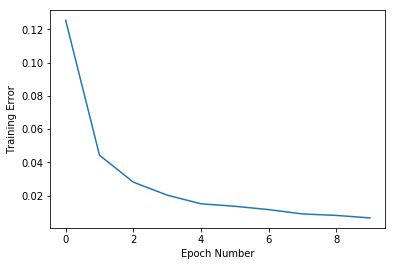

In [71]:
plt.plot(train_error)
plt.ylabel("Training Error")
plt.xlabel("Epoch Number")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

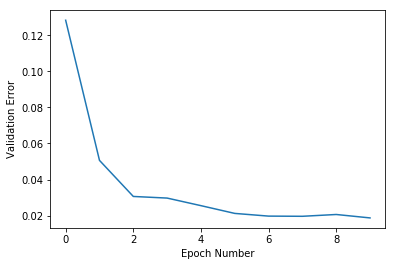

In [72]:
plt.plot(val_error)
plt.ylabel("Validation Error")
plt.xlabel("Epoch Number")
plt.show

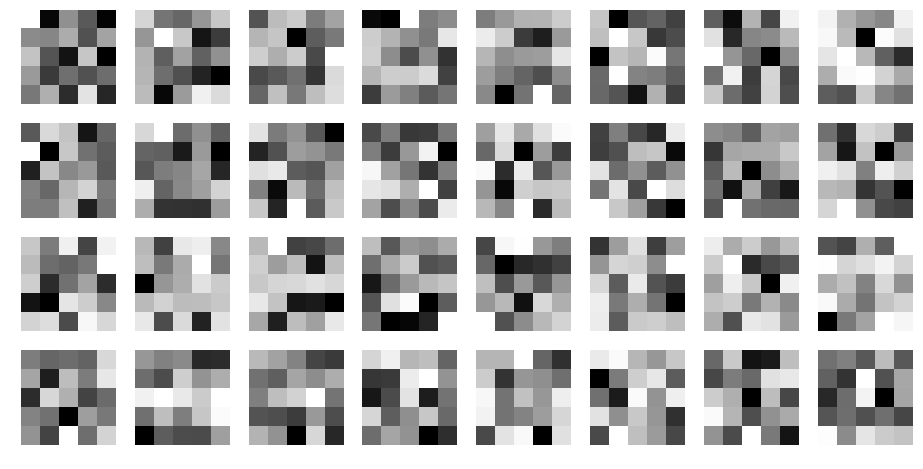

In [73]:
rows = 4
cols = 8
filters_reshape = filters.reshape(-1, 5, 5)
filters_reshape.shape
plt.figure(figsize=(cols*2, rows*2))
for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.imshow(filters_reshape[i], cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

In [74]:
def create_network_half():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=16)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=128)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [75]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=20
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

train_error_half = []
val_error_half = []

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network_half()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                train_error_half.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                val_error_half.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                
                
                # Test set accuracy
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
        var = [v for v in tf.trainable_variables() if v.name == 'conv1/W:0'][0]
        filters = var.eval(session=sess)

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

(70000, 784)
conv1/W:0 [5, 5, 1, 16] 0.06848196
conv1/b:0 [16] 0.0
conv2/W:0 [5, 5, 16, 64] 0.031595457
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 128] 0.024750415
fc1/b:0 [128] 0.0
fc2/W:0 [128, 10] 0.120775774
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.716637134552002
get stats time 0.19633984565734863
Epoch 0 Train loss, accuracy 0.4530625040888787 0.8575999999999999
get stats time 0.17267060279846191
EPoch 0 Validation loss, accuracy 0.45889875921010964 0.8531000000000001
Batch 0.0
Batch 10.0
Epoch time 0.5134241580963135
Batch 0.0
Batch 10.0
Epoch time 0.5131039619445801
get stats time 0.17801523208618164
Epoch 2 Train loss, accuracy 0.1904784416437149 0.9442
get stats time 0.17853903770446777
EPoch 2 Validation loss, accuracy 0.19456516190767287 0.9416
Batch 0.0
Batch 10.0
Epoch time 0.5160214900970459
Batch 0.0
Batch 10.0
Epoch time 0.5144002437591553
get stats time 0.17793726921081543
Epoch 4 Train loss, accuracy 0.12452974933385852 0.9628000000000002
get stats time 0.1786274909

In [76]:
cal_total_param()

428906


<function matplotlib.pyplot.show(*args, **kw)>

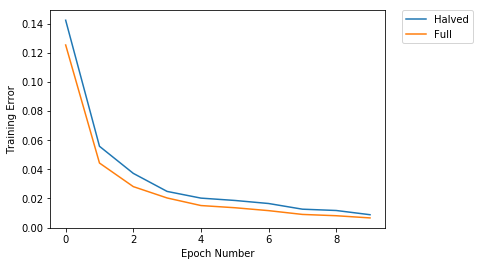

In [80]:
plt.plot(train_error_half, label="Halved")
plt.plot(train_error, label="Full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Training Error")
plt.xlabel("Epoch Number")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

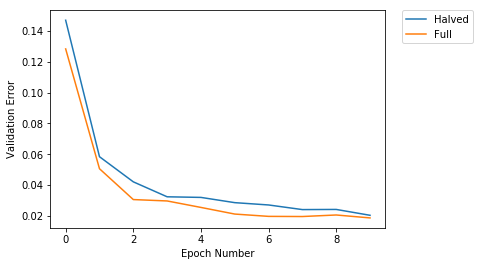

In [81]:
plt.plot(val_error_half, label="Halved")
plt.plot(val_error, label="Full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Validation Error")
plt.xlabel("Epoch Number")
plt.show

In [82]:
def create_network_double():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=64)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=512)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [85]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=20
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

train_error_double = []
val_error_double = []

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network_double()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                train_error_double.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                val_error_double.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                
                
                # Test set accuracy
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
        var = [v for v in tf.trainable_variables() if v.name == 'conv1/W:0'][0]
        filters = var.eval(session=sess)

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

(70000, 784)
conv1/W:0 [5, 5, 1, 64] 0.03478663
conv1/b:0 [64] 0.0
conv2/W:0 [5, 5, 64, 64] 0.025032356
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 512] 0.023402262
fc1/b:0 [512] 0.0
fc2/W:0 [512, 10] 0.062556356
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 1.1544742584228516
get stats time 0.3473384380340576
Epoch 0 Train loss, accuracy 0.35320790209770203 0.8931999999999999
get stats time 0.33716726303100586
EPoch 0 Validation loss, accuracy 0.36898394693136216 0.8892
Batch 0.0
Batch 10.0
Epoch time 0.9669408798217773
Batch 0.0
Batch 10.0
Epoch time 0.9571747779846191
get stats time 0.33084964752197266
Epoch 2 Train loss, accuracy 0.121284090590477 0.9644999999999999
get stats time 0.3372788429260254
EPoch 2 Validation loss, accuracy 0.1344132376551628 0.9591
Batch 0.0
Batch 10.0
Epoch time 0.9659862518310547
Batch 0.0
Batch 10.0
Epoch time 0.9638991355895996
get stats time 0.33212971687316895
Epoch 4 Train loss, accuracy 0.07185853551626205 0.9773
get stats time 0.3383965492248535
EPoch 4

In [86]:
cal_total_param()

1715402


<function matplotlib.pyplot.show(*args, **kw)>

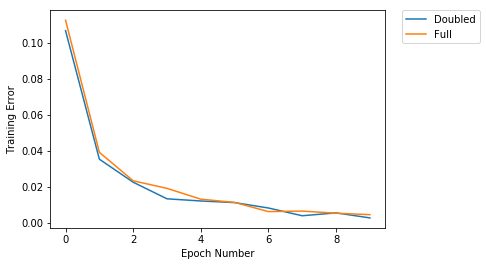

In [88]:
plt.plot(train_error_double, label="Doubled")
plt.plot(train_error, label="Full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Training Error")
plt.xlabel("Epoch Number")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

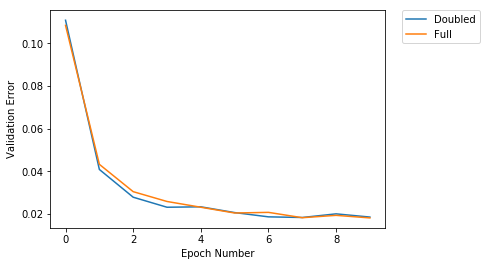

In [89]:
plt.plot(val_error_double, label="Doubled")
plt.plot(val_error, label="Full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Validation Error")
plt.xlabel("Epoch Number")
plt.show

In [1]:
## tf.reset_default_graph()

def create_network_fourth():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=8)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=64)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [13]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=20
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

train_error_fourth = []
val_error_fourth = []

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network_fourth()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                train_error_fourth.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                val_error_fourth.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                
                
                # Test set accuracy
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
        var = [v for v in tf.trainable_variables() if v.name == 'conv1/W:0'][0]
        filters = var.eval(session=sess)

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

(70000, 784)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

conv1/W:0 [5, 5, 1, 8] 0.09118633
conv1/b:0 [8] 0.0
conv2/W:0 [5, 5, 8, 64] 0.033194732
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 64] 0.025023326
fc1/b:0 [64] 0.0
fc2/W:0 [64, 10] 0.16305201
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 10.993046760559082
get stats time 0.2185814380645752
Epoch 0 Train loss, accuracy 0.6320434218168258 0.8070999999999999
get stats time 0.13588714599609375
EPoch 0 Validation loss, accuracy 0.6342360939264298 0.8117000000000001
Batch 0.0
Batch 10.0
Epoch time 0.4004664421081543
Batch 0.0
Batch 10.0
Epoch time 0.3889331817626953
get stats time 0.13016796112060547
Epoch 2 Train loss, accuracy 0.2521750141263008 0.9254
get stats time 0.12877869606018066
EPoch 2 Validation loss, accuracy 0.26224065948724745 0.9226000000000001
Batch 0.0
Batch 10.0
Epoch time 0.39

In [16]:
cal_total_param()

214490


<function matplotlib.pyplot.show(*args, **kw)>

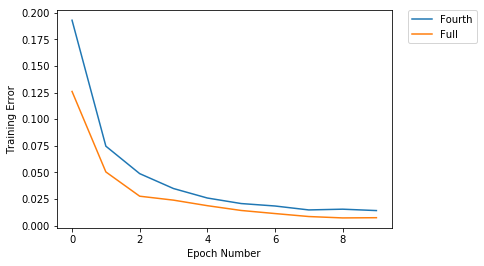

In [20]:
plt.plot(train_error_fourth, label="Fourth")
plt.plot(train_error, label="Full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Training Error")
plt.xlabel("Epoch Number")
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

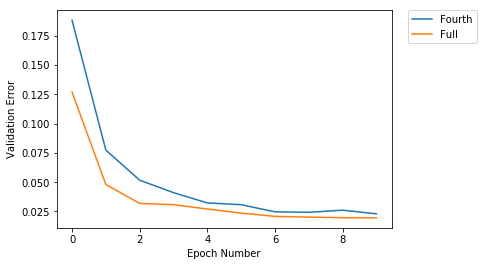

In [21]:
plt.plot(val_error_fourth, label="Fourth")
plt.plot(val_error, label="Full")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Validation Error")
plt.xlabel("Epoch Number")
plt.show

In [2]:
## tf.reset_default_graph()

def create_network_deep():
    pool_ksize=[1,4,4,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=16)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=32)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv3"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu3 = conv_relu_layer(pool2, filter_size=[5,5],num_features=64)
#             pool3 = tf.nn.max_pool(relu3, ksize=pool_ksize, strides=pool_strides, padding='SAME')       
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(relu3,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [22]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=20
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3


tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

train_error_deep = []
val_error_deep = []

with tf.Session() as sess:
        train,val,test=get_data(data_set=data_set)
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network_deep()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,2)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                train_error_deep.append(1-ac)
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                val_error_deep.append(1-vac)
                print('EPoch',i,'Validation loss, accuracy',vlo,vac)
                
                
                # Test set accuracy
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0], y_:test[1]}))
        var = [v for v in tf.trainable_variables() if v.name == 'conv1/W:0'][0]
        filters = var.eval(session=sess)

        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

(70000, 784)
conv1/W:0 [5, 5, 1, 16] 0.06776101
conv1/b:0 [16] 0.0
conv2/W:0 [5, 5, 16, 32] 0.040832512
conv2/b:0 [32] 0.0
conv3/W:0 [5, 5, 32, 64] 0.02896966
conv3/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.024267867
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08567469
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.668022871017456
get stats time 0.21513843536376953
Epoch 0 Train loss, accuracy 0.3638246850490571 0.8873000000000001
get stats time 0.18950605392456055
EPoch 0 Validation loss, accuracy 0.3494980298399925 0.8899000000000001
Batch 0.0
Batch 10.0
Epoch time 0.5636894702911377
Batch 0.0
Batch 10.0
Epoch time 0.5669300556182861
get stats time 0.1897284984588623
Epoch 2 Train loss, accuracy 0.12037993136644362 0.9644
get stats time 0.19127821922302246
EPoch 2 Validation loss, accuracy 0.11503797382116317 0.9630000000000001
Batch 0.0
Batch 10.0
Epoch time 0.5627243518829346
Batch 0.0
Batch 10.0
Epoch time 0.5639078617095947
get stats time 0.18983960151672363
Epoch 4 Train loss, accuracy 0

In [23]:
cal_total_param()

870154


(70000, 784)


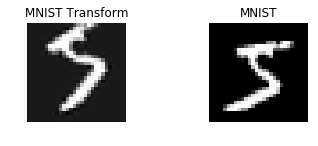

In [56]:
data_set="mnist_transform"
test = get_data(data_set=data_set)
test1 = get_data("mnist")
#First image
pixels = test[0][0].reshape((28, 28))
pixels1 = test1[0][0][0].reshape((28,28))
plt.subplot(221)
plt.axis('off')
plt.title("MNIST Transform")
plt.imshow(pixels, cmap='gray')
plt.subplot(222)
plt.axis('off')
plt.title("MNIST")
plt.imshow(pixels1, cmap='gray')
plt.show()

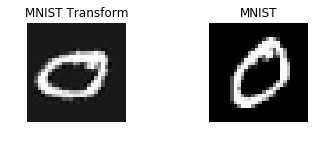

In [55]:
#Second image
pixels = test[0][1].reshape((28, 28))
pixels1 = test1[0][0][1].reshape((28,28))
plt.subplot(221)
plt.axis('off')
plt.title("MNIST Transform")
plt.imshow(pixels, cmap='gray')
plt.subplot(222)
plt.axis('off')
plt.title("MNIST")
plt.imshow(pixels1, cmap='gray')
plt.show()

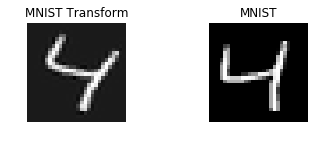

In [54]:
#Third image
pixels = test[0][2].reshape((28, 28))
pixels1 = test1[0][0][2].reshape((28,28))
plt.subplot(221)
plt.axis('off')
plt.title("MNIST Transform")
plt.imshow(pixels, cmap='gray')
plt.subplot(222)
plt.axis('off')
plt.title("MNIST")
plt.imshow(pixels1, cmap='gray')
plt.show()

In [88]:
# Run the training
tf.reset_default_graph()

def create_network():
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

import time
batch_size=500
step_size=.001
num_epochs=10
num_train=10000
minimizer="Adam"
data_set="mnist"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3


x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

error_rate = [] 
val_acc = []
with tf.Session() as sess:
        train, val, test = get_data(data_set=data_set)
        test = get_mnist_trans()
        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,1)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                error_rate.append(1 - vac)
                val_acc.append(vac)
                print('Epoch',i,'Validation loss, accuracy',vlo,vac)
                
                # Test set accuracy
        test = get_data(data_set="mnist_transform")
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0][:2000], y_:test[1][:2000]}))



        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.04989539
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.02889792
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.024292512
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.08624275
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Epoch time 0.8615844249725342
get stats time 0.25427865982055664
Epoch 0 Train loss, accuracy 0.38536952252387996 0.8846
get stats time 0.225508451461792
Epoch 0 Validation loss, accuracy 0.3835215898275376 0.8907
Batch 0.0
Batch 10.0
Epoch time 0.690941572189331
get stats time 0.231489896774292
Epoch 1 Train loss, accuracy 0.21341892116069797 0.9422
get stats time 0.22696375846862793
Epoch 1 Validation loss, accuracy 0.21638916919231416 0.9372999999999999
Batch 0.0
Batch 10.0
Epoch time 0.6928486824035645
get stats time 0.2328028678894043
Epoch 2 Train loss, accuracy 0.14771126005649565 0.9546999999999999
get stats time 0.22730445861816406
Epoch 2 Validation loss, accuracy 0.14758757240772247 0.9538
Batch 0.0
Batch 10.0
Epoch time 0.6891636848449707


<function matplotlib.pyplot.show(*args, **kw)>

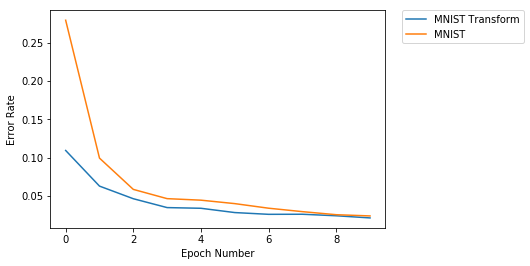

In [89]:
plt.plot(error_rate, label="MNIST Transform")
mnist_error = [x + y for x, y in zip(val_error, train_error)]
plt.plot(mnist_error, label="MNIST")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel("Error Rate")
plt.xlabel("Epoch Number")
plt.show

In [90]:
tf.reset_default_graph()

def create_network_changes():
    pool_ksize=[1,10,10,1]
    pool_strides=[1,2,2,1]
    # The network:
    with tf.variable_scope("conv1"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu1 = conv_relu_layer(x_image, filter_size=[5, 5],num_features=32)
            pool1 = tf.nn.max_pool(relu1, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope("conv2"):
            # Variables created here will be named "conv1/weights", "conv1/biases".
            relu2 = conv_relu_layer(pool1, filter_size=[5, 5],num_features=64)
            pool2 = tf.nn.max_pool(relu2, ksize=pool_ksize, strides=pool_strides, padding='SAME')
    with tf.variable_scope('dropout2'):
            drop2=tf.nn.dropout(pool2,keep_prob)
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(drop2, num_features=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, num_features=10)

    # Names (OUT,LOSS, ACC) below added to make it easier to use this tensor when restoring model
    fc2 = tf.identity(fc2, name="OUT")
    # The loss computation
    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=fc2),name="LOSS")

    # Accuracy computation
    with tf.variable_scope('helpers'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    # We return the final functions (they contain all the information about the graph of the network)
    return cross_entropy, accuracy, fc2

In [91]:
# Run the training

import time
batch_size=500
step_size=.001
num_epochs=10
num_train=30000
minimizer="Adam"
data_set="mnist"
model_name="model"
keep_prob=.5
dim=28
nchannels=1
if (data_set=="cifar"):
    dim=32
    nchannels=3


x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
x_image = tf.reshape(x, [-1, dim, dim, nchannels])
# Dimensions of x_image: [Batch size, Column size, Row size, Number of incoming channels]
# The number of incoming channels, for example, will be 3 if the image is color: RGB (red, green, blue)
# We will slide filter over this 2d picture with conv2d function.
y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")
# Allows you to control the time step during the iterations
lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")
keep_prob_=tf.placeholder(tf.float32, shape=[],name="keep_prob")

#error_rate_changes = [] 
val_acc_changes = []
trans = get_data(data_set='mnist_transform')
val = (trans[0][0:10000], trans[1][:10000])
test = (trans[0][10000:20000], trans[1][:20000])

with tf.Session() as sess:
        train, val, test = get_data(data_set=data_set)
        val = (trans[0][0:10000], trans[1][:10000])
        test = (trans[0][10000:20000], trans[1][:20000])


        # Create the network architecture with the above placeholdes as the inputs.
        cross_entropy, accuracy, fc2 =create_network_changes()

        # Define the miminization method
        if (minimizer=="Adam"):
            train_step=tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
        elif (minimizer=="SGD"):
            train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
        # Initialize variables
        sess.run(tf.global_variables_initializer())
        # Show trainable variables
        for v in tf.trainable_variables():
            print(v.name,v.get_shape().as_list(),np.std(v.eval()))
        ii=np.arange(0,num_train,1) #len(train_data),1)
        # Run epochs
        for i in range(num_epochs):  # number of epochs
            run_epoch(train,val,ii,batch_size,train_step)
            if (np.mod(i,1)==0):
                lo,ac = get_stats(train[0][0:num_train],train[1][0:num_train])
                print('Epoch',i,'Train loss, accuracy',lo,ac)
                vlo,vac = get_stats(val[0],val[1])
                #error_rate_changes.append(1 - vac)
                val_acc_changes.append(vac)
                print('Epoch',i,'Validation loss, accuracy',vlo,vac)
                
                # Test set accuracy
        test = get_data(data_set="mnist_transform")
        print('test accuracy %g' % accuracy.eval(feed_dict={x: test[0][:2000], y_:test[1][:2000]}))



        # Save model
        tf.add_to_collection("optimizer", train_step)
        saver = tf.train.Saver()
        save_path = saver.save(sess, "tmp/"+model_name)
        print("Model saved in path: %s" % save_path)

(70000, 784)
conv1/W:0 [5, 5, 1, 32] 0.049145773
conv1/b:0 [32] 0.0
conv2/W:0 [5, 5, 32, 64] 0.028913932
conv2/b:0 [64] 0.0
fc1/W:0 [3136, 256] 0.024294408
fc1/b:0 [256] 0.0
fc2/W:0 [256, 10] 0.085829765
fc2/b:0 [10] 0.0
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Epoch time 3.265199661254883
get stats time 1.0620920658111572
Epoch 0 Train loss, accuracy 0.1666302656054497 0.9488333333333332
get stats time 0.34836816787719727
Epoch 0 Validation loss, accuracy 1.471032174062729 0.5914999999999998
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Epoch time 3.1695549488067627
get stats time 1.0384933948516846
Epoch 1 Train loss, accuracy 0.112310835591952 0.9644
get stats time 0.3484516143798828
Epoch 1 Validation loss, accuracy 1.2212566663384437 0.6372000000000002
Batch 0.0
Batch 10.0
Batch 20.0
Batch 30.0
Batch 40.0
Batch 50.0
Epoch time 3.1752240657806396
get stats time 1.0415937900543213
Epoch 2 Train loss, accuracy 0.09002733979225158 0.971000000

Thus, we were able to increase the test accuracy of the model by providing small changes to the network architecture. The test accuracy increased from initially being 0.5325 for the intial model, to 0.7245 for the new updated model.